# MODELO PROBABILISTA: NAÏVE BAYES

In [1]:
import findspark
findspark.init()

import pyspark                                 # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

In [2]:
# Leemos los parquets
train_data = spark.read.parquet("train_spark.parquet")
test_data = spark.read.parquet("test_spark.parquet")

# Mostramos para verificar
print("TRAIN")
train_data.show(1, truncate=True)
print("TEST")
test_data.show(1, truncate=True)

TRAIN
+------------+--------------------+------+--------+-------------+-------+--------+-------------------+-----------------+-----------------+-------------------+-----------------------------+-------------------------+---------------------+----+-------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-------+-------+-------+-------+-------------------+------------------------+-----------------+------------------+-------------+-----------------------+----------------------+---------------+-------------------+-------------------+--------------------+---------+---------------------+----------------------+-----------------------+------------------------------+----------------------------------+----------------------------------+-------------------------------+-----------------+
|takeoff_time|           timestamp|  icao|callsign|holding_point| runway|operator|turbulence_category|last_min_takeoffs|last_m

## REPRESENTACIÓN GRÁFICA

 1. Agrupar por callsign y quedarte con el timestamp más reciente

In [3]:
import pyspark.sql.functions as f
from pyspark.sql.window import Window

import pyspark.sql.functions as f
from pyspark.sql.window import Window

def get_latest_per_callsign(df):
    """
    Para cada 'callsign', selecciona la fila con el timestamp más reciente.
    """
    # Definir la ventana
    window_spec = Window.partitionBy("callsign").orderBy(f.col("timestamp").desc())
    
    # Añadir columna de número de fila
    df_with_rownum = df.withColumn("row_number", f.row_number().over(window_spec))
    
    # Filtrar la fila más reciente de cada 'callsign'
    latest_per_callsign = df_with_rownum.filter(f.col("row_number") == 1).drop("row_number")
    
    return latest_per_callsign

In [4]:
train_data_graph = get_latest_per_callsign(train_data)
test_data_graph = get_latest_per_callsign(test_data)

2. Histograma y Boxplot (usando takeoff_time como ejemplo de variable respuesta)

Para visualizar estos gráficos, lo más práctico es convertir el resultado a un pandas.DataFrame:

Ahora puedes usar matplotlib o seaborn:

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distribution(df, feature_col):
    """
    Dado un dataframe de Spark, selecciona una columna y genera el histograma y boxplot usando pandas + seaborn.
    """
    # Convertimos a pandas (precaución: solo si no es demasiado grande)
    feature_pd = df.select(feature_col).toPandas()
    
    # Histograma
    plt.figure(figsize=(10, 4))
    sns.histplot(feature_pd[feature_col], bins=30, kde=True)
    plt.title(f"Histograma de {feature_col}")
    plt.xlabel(feature_col)
    plt.ylabel("Frecuencia")
    plt.show()

    # Boxplot
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=feature_pd[feature_col])
    plt.title(f"Boxplot de {feature_col}")
    plt.xlabel(feature_col)
    plt.show()

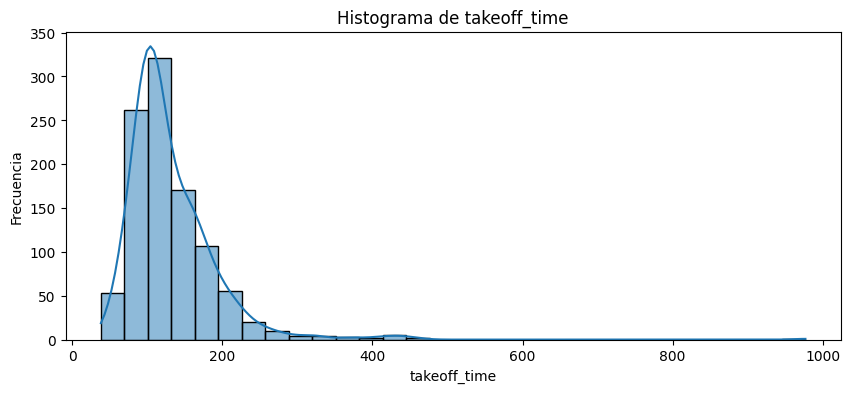

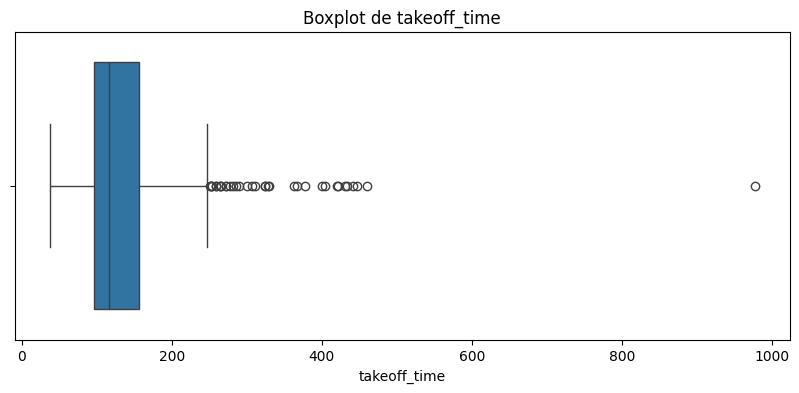

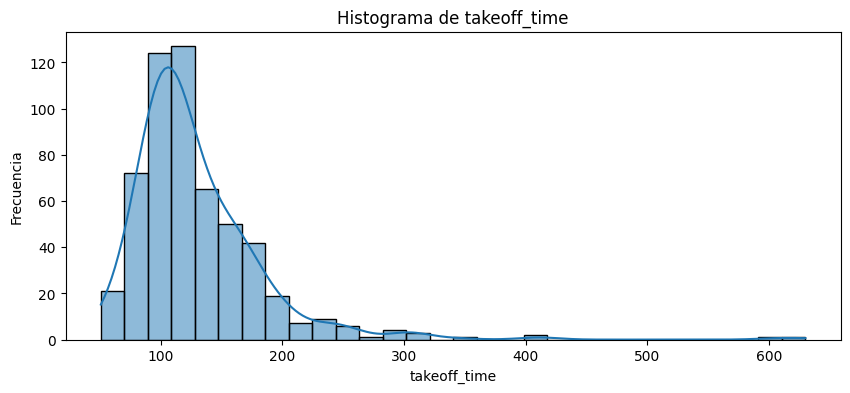

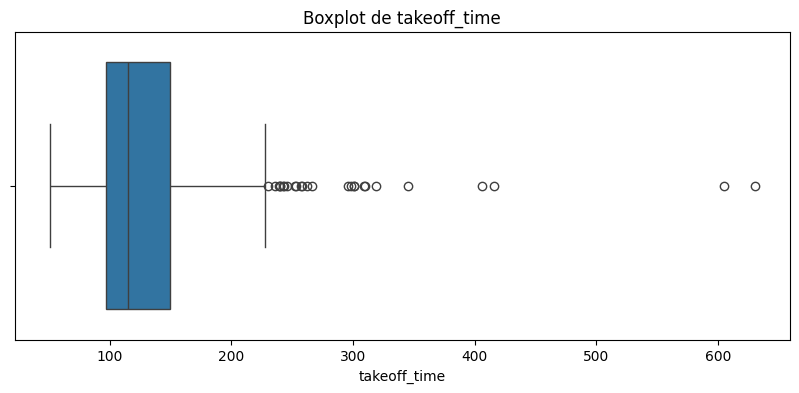

In [6]:
# Graficar la distribución de la variable 'takeoff_time' en train
plot_feature_distribution(train_data_graph, "takeoff_time")

# Si quisieras también graficar en test
plot_feature_distribution(test_data_graph, "takeoff_time")

**¿Qué representa cada barra del histograma?**

Cada barra del histograma te dice cuántos aviones (últimos mensajes) tenían un determinado valor (o rango) de takeoff_time.
Por ejemplo:
- Una barra centrada en 100 te diría que hay varios mensajes cuyo takeoff_time era de 100 segundos antes de despegar.
- Una barra cerca de 0 significa mensajes muy pegados al despegue.

**¿Qué representa este boxplot exactamente?**

El boxplot que estamos generando representa cómo se distribuye el tiempo restante hasta el despegue (takeoff_time, en segundos) justo en el último mensaje de cada callsign.

- Cada punto del boxplot es un avión, representado por su último mensaje antes del despegue.
- El valor en el eje X es el número de segundos que faltaban para el despegue en ese momento (takeoff_time).
- Estás visualizando cómo se agrupan estos tiempos:
    - La caja central muestra el 50% de los vuelos con tiempos más cercanos a la mediana.
    - Las "whiskers" (líneas que salen de la caja) muestran el rango de valores más comunes.
    - Los puntos fuera de las whiskers son potenciales outliers: mensajes enviados muy lejos o muy cerca del despegue comparado con el resto.

## VARIABLE OBJETIVO

Vamos a predecir si un avión ha despegado en el siguiente estado (es decir, si despega o no tras un determinado momento, midámoslo, por ejemplo, en minutos), entonces vamos a necesitar una variable objetivo binaria que indique si el avión despegó o no después de ese instante (después de ese minuto).

De momento, tenemos columnas que puedan aportar pistas, pero no son directamente una variable binaria que haga referencia a lo que queremos predecir.

- 'takeoff_time' ✅ → Esta es la más prometedora, pues indica el tiempo que trascurre desde que llega a un punto de espera hasta que finalmente despega (en segundos).


Entonces, el objetivo es predecir si un avión va a despegar o no en el estado siguiente, por lo que vamos a medir un estado entero como 30 segundos. Es decir, predeciremos si un avión va a despegar o no en los próximos 30 segundos (este dato nos lo da la variable ```takeoff_time```)

La variable objetivo se llamará ```will_takeoff_afterX```, y tomará el valor:
- ```0```: si despegará de 0 a 30 segundos
- ```1```: si despegará de 30 a 60 segundos
- ```2```: si despegará de 60 a 90 segundos
- ```3```: si despegará de 90 a 120 segundos
- ```4```: si despegará de 120 a 150 segundos
- ```5```: si despegará de 150 a 180 segundos
- ```6```: si despegará a partir de los 180 segundos

Por tanto, se trata de una variable categórica multiclase.

La decisión de los 100 segundos se escogió tras un análisis exhaustivo de los datos de los que disponemos actualmente, mostrando el histograma de distribución del tiempo de despegue de los aviones (```takeoff_time```), donde pudimos ver que el valor en el que había más frecuencia de ejemplos era a los 100 segundos, y que esa frecuencia iba menguando hasta los 400 segundos, donde dejó de ser notoria. 

In [7]:
def create_target_variable(df, source_col="takeoff_time", target_col="will_takeoff_afterX"):
    """
    Crea una variable categórica (target) basada en rangos de la columna source_col.
    Los rangos que se crean son:
    - < 30 --> 0
    - < 60 --> 1
    - < 90 --> 2
    - < 120 --> 3
    - < 150 --> 4
    - < 180 --> 5
    - >= 180 --> 6
    """
    df = df.withColumn(target_col,
        f.when(f.col(source_col) < 30, 0)
         .when(f.col(source_col) < 60, 1)
         .when(f.col(source_col) < 90, 2)
         .when(f.col(source_col) < 120, 3)         
         .when(f.col(source_col) < 150, 4)
         .when(f.col(source_col) < 180, 5)
         .otherwise(6)
    )
    return df

In [8]:
# Aplicar sobre train y test
train_data_with_target = create_target_variable(train_data_graph)
test_data_with_target = create_target_variable(test_data_graph)

# Verificar
train_data_with_target.select("takeoff_time", "will_takeoff_afterX").show(5, truncate=False)
test_data_with_target.select("takeoff_time", "will_takeoff_afterX").show(5, truncate=False)

# Contar la distribución de clases
train_data_with_target.groupby("will_takeoff_afterX").count().show()
test_data_with_target.groupby("will_takeoff_afterX").count().show()

+------------+-------------------+
|takeoff_time|will_takeoff_afterX|
+------------+-------------------+
|79.0        |2                  |
|102.0       |3                  |
|88.0        |2                  |
|99.0        |3                  |
|138.0       |4                  |
+------------+-------------------+
only showing top 5 rows

+------------+-------------------+
|takeoff_time|will_takeoff_afterX|
+------------+-------------------+
|71.0        |2                  |
|121.0       |4                  |
|134.0       |4                  |
|125.0       |4                  |
|146.0       |4                  |
+------------+-------------------+
only showing top 5 rows

+-------------------+-----+
|will_takeoff_afterX|count|
+-------------------+-----+
|                  1|   18|
|                  6|  145|
|                  3|  368|
|                  5|  141|
|                  4|  182|
|                  2|  165|
+-------------------+-----+

+-------------------+-----+
|will_takeo

## FEATURE SELECTION


Hay varias columnas que no aportan valor predictivo o que podrían introducir fuga de información (data leakage) si las usamos para predecir si un avión va a despegar en el siguiente instante.

**NOTA**: Este es el análisis teórico de las variables, aunque ya las analizamos prácticamente durante el ejercicio 1 (modelos no probabilistas), donde fueron eliminadas las que debían eliminarse.

**✅ Columnas útiles o potencialmente relevantes:**

Estas columnas sí podrías considerar para el modelo:
- ```'holding_point'```, ```'runway'```, ```'operator'```, ```'turbulence_category'```
- ```'lat'```, ```'lon'``` (posición actual del avión)
- ```'last_min_takeoffs'```, ```'last_min_landings'```, ```'time_since_last_event_seconds'```
- ```'time_before_holding_point'```, ```'time_at_holding_point'```
- ```'hour'```, ```'weekday'```, ```'is_holiday'```
- Condiciones meteorológicas: ```'temperature_2m (°C)'```, ```'rain (mm)'```, ```'wind_speed_10m (km/h)'```, etc.
- ```'is_day ()'```, ```'weather_code (wmo code)'```
- ```'36R_18L'```, ```'32R_14L'```, etc. (si son booleanos indicando pista activa, podrían ser útiles)

------------


**🟡 Columnas dudosas / posiblemente redundantes (pt1):**

- ```'first_holding_time'```: puede reflejar un paso previo al despegue, pero si se genera después del despegue, también sería fuga.
- ```'last_event'```, ```'last_event_turb_cat'```: cuidado, podrían tener fugas si reflejan eventos después del despegue.

**🟡 Columnas dudosas / posiblemente redundantes (pt2):**

- ```'Z1'```, ```'KA6'```, ```'KA8'```, etc.: no está claro qué representan (¿zonas del aeropuerto?). Si son categóricas, podrías mantenerlas si crees que influyen en el comportamiento del avión.

**Recomendaciones basadas en el análisis**:
- Eliminar columnas con frecuencia muy baja (```Z6```, ```LA```, ```LB```, ```KA6```, ```KA8```) si estás preparando datos para un modelo de ML.
- Explorar más profundamente las relaciones entre ```K1```, ```K2```, ```K3```, ```Y1```, y las combinaciones de lados (```36R_18L```, etc.).
- Considerar usar otra métrica para datos booleanos, como correlación de Phi o coeficiente de Jaccard, si te interesa más precisión en variables binarias.
------------------------------
**❌ Columnas que deberíamos quitar del modelo:**

1. Variables que contienen o dependen del futuro: Estas variables contienen el resultado que estamos intentando predecir. Usarlas sería trampa (data leakage).
- ```'takeoff_time'```
- ```'first_airborne_time'```
- ```'first_on_ground_time'```
- ```'event_timestamp'``` (depende del evento registrado, podría estar ya posterior al despegue)
Pero, en cambio, ya las hemos usado para modelar la variable objetivo.

2. Variables que son ID o irrelevantes para el modelo: Estas no aportan información útil para predecir, o son identificadores únicos.
- ```'icao'``` (identificador del avión)
- ```'callsign'``` (también es identificador específico del vuelo)
- ```'timestamp'``` y ```'time'``` (pueden ser redundantes o innecesarios si ya tienes 'hour', 'weekday', etc.)
-------------------

In [9]:
cols_to_drop = [
    'takeoff_time', 'first_airborne_time', 'first_on_ground_time', 'event_timestamp',
    'icao', 'callsign', 'time', 'first_holding_time', '__index_level_0__'
]
# solo quedaría timestamp, que no lo vamos a eliminar porque lo necesitamos para ordenar

train_data_with_target = train_data_with_target.drop(*cols_to_drop)
train_data_with_target.show(1, truncate=False)

test_data_with_target = test_data_with_target.drop(*cols_to_drop)
test_data_with_target.show(1, truncate=False)

+-----------------------+-------------+-------+--------+-------------------+-----------------+-----------------+-------------------+-----------------------------+-------------------------+---------------------+----+-------+----------+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-------+-------+-------+-------+-------------------+------------------------+-----------------+------------------+-------------+-----------------------+----------------------+---------------+-------------------+-------------------+--------------------+---------+---------------------+----------------------+-----------------------+------------------------------+----------------------------------+----------------------------------+-------------------------------+-------------------+
|timestamp              |holding_point|runway |operator|turbulence_category|last_min_takeoffs|last_min_landings|last_event_turb_cat|time_since_last_event_se

## VALIDACIÓN

In [10]:
# Obtener la última fecha en train_data_with_target
max_timestamp = train_data_with_target.agg(f.max("timestamp")).collect()[0][0]

print("Última fecha en train_data_with_target:", max_timestamp)

Última fecha en train_data_with_target: 2025-01-14 22:29:16.437000


In [11]:
train_data_with_target.select("timestamp").orderBy("timestamp", ascending=False).show(10, truncate=False)

+-----------------------+
|timestamp              |
+-----------------------+
|2025-01-14 22:29:16.437|
|2025-01-14 19:59:59.993|
|2025-01-14 18:58:51.044|
|2025-01-14 18:23:38.839|
|2025-01-14 18:21:31.786|
|2025-01-14 18:17:57.832|
|2025-01-14 18:12:40.163|
|2025-01-14 16:14:40.099|
|2025-01-14 16:10:58.865|
|2025-01-14 15:59:59.903|
+-----------------------+
only showing top 10 rows



In [12]:
# -- Crear un corte temporal dentro de train_data --
# Por ejemplo, usar como validación el x% más reciente de train_data
# que corresponde a los días 1 a 14 de enero
from pyspark.sql import functions as f

# Definir el rango de validación: del 1 al 14 de enero de 2024
validation_fold = train_data_with_target.filter(
    (f.col("timestamp") >= f.lit("2025-01-01 00:00:00.000000")) & 
    (f.col("timestamp") <= f.lit("2025-01-14 23:59:59.999999"))
)

# El resto para entrenamiento
train_fold = train_data_with_target.filter(
    (f.col("timestamp") < f.lit("2025-01-01 00:00:00.000000"))
)

print(f"Train fold size: {train_fold.count()}, Validation fold size: {validation_fold.count()}")


Train fold size: 509, Validation fold size: 510


## DISEÑO DEL MODELO NAÏVE BAYES

### Consideraciones:

1. La variable a predecir es ```will_takeoff_afterX```.
2. Usaremos ```weight``` para darle más importancia a las clases minoritarias en el entrenamiento del modelo.
3. Eliminamos todas las variables que puedan tener valores negativos (Naïve Bayes no soporta negativos para el entrenamiento).
4. Indexaremos las columnas categóricas.
5. Dentro del conjunto de train, hemos establecido un corte temporal del 1 al 14 de enero para dividir en conjunto de validación (dentro de ese corte) y entrenamiento (observaciones fuera del corte).
6. La validación se realizará con el método "Hold-out temporal".

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# 1. Contar instancias por clase en el train
label_counts = train_data_with_target.groupBy("will_takeoff_afterX").count().toPandas()

# 2. Calcular el peso inverso para cada clase
total = label_counts["count"].sum()
label_counts["weight"] = total / (len(label_counts) * label_counts["count"])

# 3. Crear el diccionario {clase: peso}
weights_dict = dict(zip(label_counts["will_takeoff_afterX"], label_counts["weight"]))

# 4. Crear UDF para asignar peso basado en la clase
def get_weight(label):
    return float(weights_dict[label])

weight_udf = udf(get_weight, DoubleType())

# 5. Añadir columna 'weight' al train y al test
train_data_with_target = train_data_with_target.withColumn("weight", weight_udf(f.col("will_takeoff_afterX")))
test_data_with_target = test_data_with_target.withColumn("weight", weight_udf(f.col("will_takeoff_afterX")))

train_fold = train_fold.withColumn("weight", weight_udf(f.col("will_takeoff_afterX")))
validation_fold = validation_fold.withColumn("weight", weight_udf(f.col("will_takeoff_afterX")))



In [14]:
# -- Librerías necesarias --
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 2. Lista de columnas predictoras
feature_cols = [c for c in train_data_with_target.columns if c not in ["will_takeoff_afterX", 'holding_point', 'runway', 'weekday','dew_point_2m (°C)', 
                                                                       'operator', 'turbulence_category', 'last_event_turb_cat', 'timestamp',
                                                                      'temperature_2m (°C)', 'soil_temperature_100_to_255cm (°C)', 'weight']]

# 3. Indexar las columnas de tipo string (categóricas)
indexers = [
    StringIndexer(inputCol="holding_point", outputCol="holding_point_index", handleInvalid="keep"),
    StringIndexer(inputCol="runway", outputCol="runway_index", handleInvalid="keep"),
    StringIndexer(inputCol="operator", outputCol="operator_index", handleInvalid="keep"),
    StringIndexer(inputCol="weekday", outputCol="weekday_index", handleInvalid="keep"),
    StringIndexer(inputCol="turbulence_category", outputCol="turbulence_category_index", handleInvalid="keep"),
    StringIndexer(inputCol="last_event_turb_cat", outputCol="last_event_turb_cat_index", handleInvalid="keep"),
]

# 4. Crear el ensamblador de características
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 5. Crear el modelo Naive Bayes (sin weightCol)
nb = NaiveBayes(featuresCol="features", labelCol="will_takeoff_afterX", weightCol="weight")

# 6. Crear el pipeline
pipeline = Pipeline(stages=indexers + [assembler, nb])

In [15]:
# 7. Entrenar el modelo
model = pipeline.fit(train_data_with_target)

In [16]:
# 8. Evaluar el modelo
predictions = model.transform(test_data_with_target)
evaluator = MulticlassClassificationEvaluator(labelCol="will_takeoff_afterX", predictionCol="prediction")

print("Accuracy:", evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print("F1 Score:", evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
print("Weighted Precision:", evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"}))
print("Weighted Recall:", evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}))

Accuracy: 0.3261261261261261
F1 Score: 0.24764555464759536
Weighted Precision: 0.24465091200108285
Weighted Recall: 0.3261261261261261


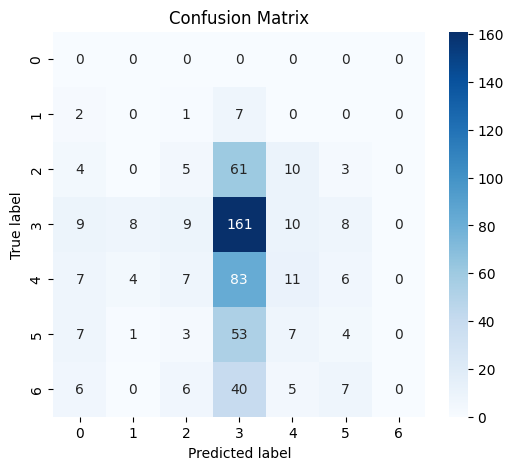

In [17]:
# 9. Matriz de confusión
y_true = [int(row['will_takeoff_afterX']) for row in predictions.select("will_takeoff_afterX").collect()]
y_pred = [int(row['prediction']) for row in predictions.select("prediction").collect()]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[x for x in range(0, 7)], yticklabels=[x for x in range(0, 7)])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

## GRIDSEARCH

In [18]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as f

# -- 1. Crear un corte temporal dentro de train_data -- 
# lo hicimos en el apartado de "Validación", tenemos train_fold y validation_fold

# -- 2. Definir Grid de hiperparámetros --
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.5, 1.0]) \
    .addGrid(nb.modelType, ["multinomial", "gaussian"]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="will_takeoff_afterX", predictionCol="prediction", metricName="accuracy")

best_model = None
best_accuracy = 0.0
best_params = None

# -- 3. Buscar mejores hiperparámetros en validation_fold --
for params in paramGrid:
    temp_pipeline = Pipeline(stages=indexers + [
        VectorAssembler(inputCols=feature_cols, outputCol="features"),
        NaiveBayes(featuresCol="features", labelCol="will_takeoff_afterX", weightCol="weight")\
            .copy(params)
    ])
    
    model = temp_pipeline.fit(train_fold)
    predictions = model.transform(validation_fold)
    
    accuracy = evaluator.evaluate(predictions)
    print(f"Params {params} ➔ Validation Accuracy: {accuracy:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_params = params

# -- 4. Reentrenar usando todo el train_data_with_target con los mejores hiperparámetros --
print("\n Mejor combinación de hiperparámetros encontrada:", best_params)

final_pipeline = Pipeline(stages=indexers + [
        VectorAssembler(inputCols=feature_cols, outputCol="features"),
        NaiveBayes(featuresCol="features", labelCol="will_takeoff_afterX", weightCol="weight")\
            .copy(params)
])

final_model = final_pipeline.fit(train_data_with_target)

# -- 5. Evaluar en test_data_with_target --
final_predictions = final_model.transform(test_data_with_target)
final_accuracy = evaluator.evaluate(final_predictions)

print(f"\n Accuracy final en test: {final_accuracy:.4f}")


Params {Param(parent='NaiveBayes_45945800b88f', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.0, Param(parent='NaiveBayes_45945800b88f', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default), bernoulli and gaussian.'): 'multinomial'} ➔ Validation Accuracy: 0.3078
Params {Param(parent='NaiveBayes_45945800b88f', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.0, Param(parent='NaiveBayes_45945800b88f', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default), bernoulli and gaussian.'): 'gaussian'} ➔ Validation Accuracy: 0.3078
Params {Param(parent='NaiveBayes_45945800b88f', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.5, Param(parent='NaiveBayes_45945800b88f', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomi